### Import Module

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


### Prepare columns of interest and specify their types

In [2]:
# Init constant var to store desired cols and their types
DTYPE_DICT = {
    "user_id": pd.Int64Dtype(),
    "status": pd.StringDtype(),
    "timestamp": pd.Int64Dtype(),
    "data.user_data.meta.is_private": pd.BooleanDtype(),
    "data.user_data.meta.is_verified": pd.BooleanDtype(),
    "data.user_data.meta.is_business_account": pd.BooleanDtype(),
    "data.user_data.meta.is_professional_account": pd.BooleanDtype(),
    "data.user_data.meta.has_reel": pd.BooleanDtype(),
    "data.user_data.meta.total_posts_count": pd.Int64Dtype(),
    "data.user_data.meta.followers_count": pd.Int64Dtype(),
    "data.user_data.meta.followings_count": pd.Int64Dtype(),
}

# Iteratively get the metrics for posts
post_column_pattern = "data.user_data.post.{}.{}"
post_metrics = {
    "is_video": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "is_pinned": pd.BooleanDtype(),
}

# Populate DTYPE_DICT with desired metrics for 12 posts
for i in range(1, 13):
    for metric, dtype in post_metrics.items():
        column_name = post_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Iteratively get the metrics for reels
reel_column_pattern = "data.user_data.reel.{}.{}"
reel_metrics = {
    "has_audio": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "video_duration": pd.Float64Dtype(),
}
        
# Populate DTYPE_DICT with desired metrics for 36 reels
for i in range(1, 37):
    for metric, dtype in reel_metrics.items():
        column_name = reel_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Get a list of desired columns (for `read_csv()`)
columns_to_read = list(DTYPE_DICT.keys())

### Read Data

In [3]:
data = pd.read_csv('.././data/input/instagram.csv',
                  encoding='utf-8',
                  index_col=False,
                  usecols=columns_to_read,
                  dtype=DTYPE_DICT,)

### Filter Data Based on Account

Filter rows:
1. Failed jobs
2. Account with no reels
3. Private accounts
4. Accounts with total posts < 12
5. Accounts with followers < ? (50 for now)

Filter columns:
1. Post-related columns
2. Account type flags
3. Other irrelevant columns


In [4]:
# Filter out the following rows
data = data.loc[
    (data['status'] == 'successful') &
    (data['data.user_data.meta.has_reel'] == True) &
    (data['data.user_data.meta.is_private'] == False) &
    (data['data.user_data.meta.total_posts_count'] >= 12) &
    (data['data.user_data.meta.followers_count'] > 50)
]

# Filter out columns with names containing "data.user_data.post"
columns_to_drop = [col for col in data.columns if 'data.user_data.post' in col]

# Filter out unary cols
columns_to_drop.extend([
    'status',
    'data.user_data.meta.has_reel',
    'data.user_data.meta.is_private',
])

# Filter out other irrelevant columns
columns_to_drop.extend(
    [
        "data.user_data.meta.is_verified",
        "data.user_data.meta.is_business_account",
        "data.user_data.meta.is_professional_account",
    ]
)

data.drop(columns=columns_to_drop, inplace=True)
data

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,data.user_data.reel.1.has_audio,data.user_data.reel.1.video_view_count,data.user_data.reel.1.comments_count,data.user_data.reel.1.comments_disabled,data.user_data.reel.1.taken_at_timestamp,...,data.user_data.reel.35.taken_at_timestamp,data.user_data.reel.35.likes_count,data.user_data.reel.35.video_duration,data.user_data.reel.36.has_audio,data.user_data.reel.36.video_view_count,data.user_data.reel.36.comments_count,data.user_data.reel.36.comments_disabled,data.user_data.reel.36.taken_at_timestamp,data.user_data.reel.36.likes_count,data.user_data.reel.36.video_duration
0,1293559,1722469534,1422,2488,2112,True,1051,1,False,1722370215,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1256735,1722469583,1614,27160,5358,True,2144,1,False,1721673822,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1334585,1722469667,250,552,278,True,232,0,False,1722373466,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,1104262,1722469699,642,2214,1784,True,1322,0,False,1722407648,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,1206869,1722469734,55,702,1232,True,987,5,False,1720877897,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,1284932,1722570803,135,4996,5258,True,3073,33,False,1710255431,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2744,1331319,1722570821,786,1679,2410,True,109,0,False,1722531756,...,1674162607,37,51.633,True,172,1,False,1673911308,42,61.633
2745,1274132,1722570839,229,1518,2238,True,356,1,False,1717043239,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2747,1333719,1722570885,51,737,765,True,568,4,False,1704155392,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Transform Account-based dataframe into Reel-based dataframe

In [5]:
melted = data.melt(
    id_vars=[
        "user_id",
        "timestamp",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
    ],
    var_name="variable",
    value_name="value",
)
melted[["reel_id", "field"]] = melted["variable"].str.extract(r"reel\.(\d+)\.(.+)")
melted.sort_values(["user_id", "reel_id", "field"])

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,variable,value,reel_id,field
4437,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_count,0,1,comments_count
6532,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_disabled,False,1,comments_disabled
247,1018408,1722473971,742,984,643,data.user_data.reel.1.has_audio,True,1,has_audio
10722,1018408,1722473971,742,984,643,data.user_data.reel.1.likes_count,6,1,likes_count
8627,1018408,1722473971,742,984,643,data.user_data.reel.1.taken_at_timestamp,1722459602,1,taken_at_timestamp
...,...,...,...,...,...,...,...,...,...
118262,1445323,1722544589,12,522,110,data.user_data.reel.9.has_audio,<NA>,9,has_audio
128737,1445323,1722544589,12,522,110,data.user_data.reel.9.likes_count,<NA>,9,likes_count
126642,1445323,1722544589,12,522,110,data.user_data.reel.9.taken_at_timestamp,<NA>,9,taken_at_timestamp
130832,1445323,1722544589,12,522,110,data.user_data.reel.9.video_duration,<NA>,9,video_duration


In [6]:
# Pivot table
transformed = melted.pivot(
    index=[
        "user_id",
        "reel_id",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
        "timestamp",
    ],
    columns="field",
    values="value",
).reset_index()

# Reassign reel metrics types
for column, dtype in reel_metrics.items():
    transformed[column] = transformed[column].astype(dtype)
transformed["reel_id"] = transformed["reel_id"].astype(pd.Int64Dtype())

# Rename index and columns
transformed.columns.name = None
transformed = transformed.rename(
    columns={
        "timestamp": "scraped_at",
        "taken_at_timestamp": "created_at",
        "data.user_data.meta.total_posts_count": "total_posts",
        "data.user_data.meta.followers_count": "followers",
        "data.user_data.meta.followings_count": "followings",
    }
)

# Convert epoch timestamp to datetime objects
transformed['created_at_timestamp'] = transformed["created_at"]
transformed['created_at'] = pd.to_datetime(transformed['created_at'], unit='s', utc=True)
transformed['created_at_pst'] = transformed['created_at'].dt.tz_convert('America/Los_Angeles')
transformed['scraped_at_timestamp'] = transformed["scraped_at"]
transformed['scraped_at'] = pd.to_datetime(transformed['scraped_at'], unit='s', utc=True)
transformed['scraped_at_pst'] = transformed['scraped_at'].dt.tz_convert('America/Los_Angeles')

transformed

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,comments_disabled,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,False,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75415,1445323,5,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
75416,1445323,6,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
75417,1445323,7,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
75418,1445323,8,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00


### Summarize cleaned data set

In [7]:
def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    summary = []
    for col in df.columns:
        column_data = df[col]
        col_summary = {
            "Column": col,
            "Data Type": column_data.dtype,
            "NA %": column_data.isna().mean() * 100,
            "Unique Values": column_data.nunique(),
            "Mean": column_data.mean() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Median": column_data.median() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Min": column_data.min() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Max": column_data.max() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Range": (column_data.max() - column_data.min()) if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Top Frequency": column_data.value_counts().iloc[0] if not column_data.isna().all() else None,
        }
        
        # Handle boolean columns
        if column_data.dtype in [pd.BooleanDtype(), bool]:
            true_count = column_data.sum()
            false_count = len(column_data) - column_data.isna().sum() - true_count
            col_summary["True Count"] = true_count
            col_summary["False Count"] = false_count
            col_summary["True %"] = (true_count / (true_count + false_count)) * 100
            col_summary["False %"] = (false_count / (true_count + false_count)) * 100
        summary.append(col_summary)

    return pd.DataFrame(summary)

# Get summary
summarize_dataframe(transformed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2095,1.217129e+06,1.225873e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.850000e+01,1.850000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2095,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,5.701761e+02,3.690000e+02,1.200000e+01,3.075500e+04,3.074300e+04,324,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1506,3.060040e+03,1.056000e+03,5.600000e+01,5.908050e+05,5.907490e+05,252,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.296164e+03,9.120000e+02,0.000000e+00,7.535000e+03,7.535000e+03,216,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2071,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,33.204720,182,3.377494e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23411,NaN,NaN,NaN,NaN
7,comments_disabled,boolean,33.204720,2,NaN,NaN,NaN,NaN,NaN,50372,5.0,50372.0,0.009925,99.990075
8,has_audio,boolean,33.206046,2,NaN,NaN,NaN,NaN,NaN,47052,47052.0,3324.0,93.401620,6.598380
9,likes_count,Int64,33.204720,722,6.402847e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3125,NaN,NaN,NaN,NaN


### Filter reels
1. Unknown posting time
2. Comments disabled
3. Video duration < 1 seconds

In [8]:
# Drop rows with N/A created_at timestamp
cleaned = transformed.dropna(subset=["created_at"])

# Drop rows with comment disabled and remove this unary column
cleaned = cleaned[cleaned["comments_disabled"] == False].drop(columns=["comments_disabled"])

# Drop rows with video duration < 1 or is NA
cleaned = cleaned[(cleaned["video_duration"] >= 1) & ~(cleaned["video_duration"].isna())]

# Preview
summarize_dataframe(cleaned)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2095,1.217377e+06,1.224850e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.471058e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2095,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.998898e+02,4.770000e+02,1.200000e+01,3.075500e+04,3.074300e+04,220,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1506,3.693748e+03,1.230000e+03,5.600000e+01,5.908050e+05,5.907490e+05,159,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.453597e+03,1.073000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2071,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,182,3.378736e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23393,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,47033,47033.0,3316.0,93.41397,6.58603
8,likes_count,Int64,0.000000,722,6.405170e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3124,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,48823,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN


### Prepare columns

#### 1. Time elapsed from posted time to scraped time (in seconds)

In [9]:
augmented = cleaned.copy()

# Free useless dfs from memory
# del data, melted, transformed, cleaned
# import gc; gc.collect()

# Calculate the time difference between scraped_at and created_at
augmented["time_elapsed"] = augmented["scraped_at"] - augmented["created_at"]
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00,0 days 03:59:29
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00,113 days 03:22:47
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00,126 days 03:53:21
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75383,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04
75384,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20
75395,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52
75406,1445323,3,12,522,110,2024-08-01 20:36:29+00:00,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,1622163121,2021-05-27 17:52:01-07:00,1722544589,2024-08-01 13:36:29-07:00,1161 days 19:44:28


Plot and see the distribution of time elapsed

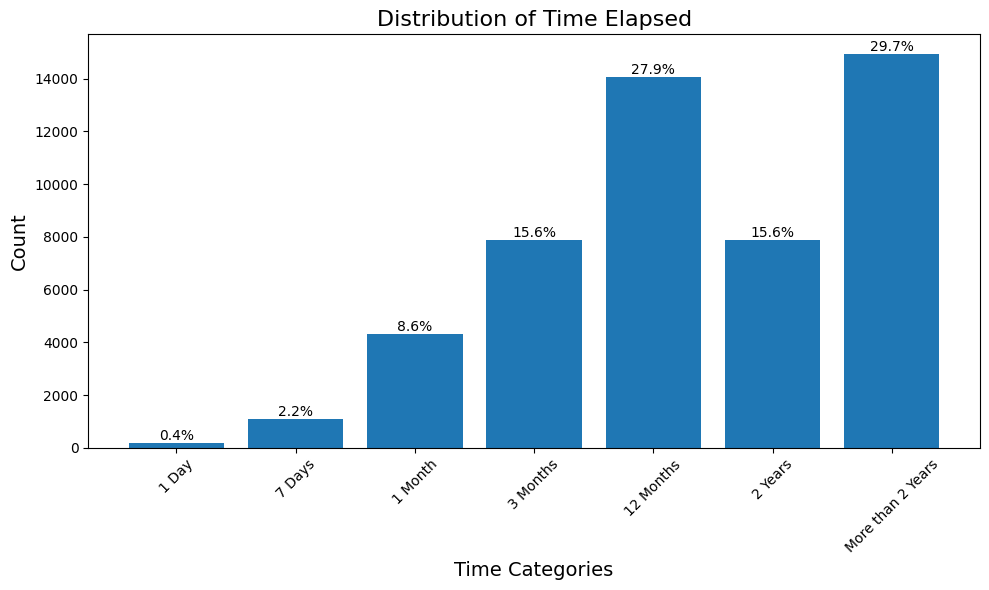

In [10]:
# Define the bin edges (in days) and labels
bins = [
    0, 
    1,             # 1 Day
    7,             # 7 Days
    30,            # 1 Month
    90,            # 3 Months
    365,           # 12 Months
    730,           # 2 Years
    float('inf')   # More than 2 Years
]
labels = [
    '1 Day', '7 Days', '1 Month', '3 Months', '12 Months', '2 Years', 'More than 2 Years',
]

# Create a new column for bins
augmented['time_elapsed_category'] = pd.cut(augmented['time_elapsed'].dt.days, bins=bins, labels=labels, right=False)

# Calculate distribution and percentages
distribution = augmented['time_elapsed_category'].value_counts().sort_index()
percentages = (distribution / len(augmented)) * 100

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(distribution.index.astype(str), distribution.values)

# Add percentage labels to each bar
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{percent:.1f}%", ha='center', va='bottom')

# Customize plot
ax.set_title("Distribution of Time Elapsed", fontsize=16)
ax.set_xlabel("Time Categories", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed,time_elapsed_category
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00,0 days 03:59:29,1 Day
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00,113 days 03:22:47,12 Months
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00,126 days 03:53:21,12 Months
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38,12 Months
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04,12 Months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75383,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04,12 Months
75384,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20,12 Months
75395,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52,More than 2 Years
75406,1445323,3,12,522,110,2024-08-01 20:36:29+00:00,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,1622163121,2021-05-27 17:52:01-07:00,1722544589,2024-08-01 13:36:29-07:00,1161 days 19:44:28,More than 2 Years


Take out reels that are less than 7 days old

We assume that reels after 7 days are receiving negligible amount of engagement, and those within posted 7 days (from the time the data was collected) are still receiving some. Since these reels consist of less than 3% of the total data, we decide to remove them.

A side note: is it more rational to make the engagement metric relative to the time elaspsed? For example, there's some scalar to be applied to reels posted within 1 day to predict what it would be like in the next week? Maybe not worth the time for just 3% of the data.

In [12]:
augmented = augmented[augmented['time_elapsed'] >= pd.Timedelta(days=7)]
# augmented.drop(columns=['time_elapsed_category'], inplace=True)  # Remove intermediate column
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2094,1.217446e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.502932e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.909835e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1505,3.597401e+03,1.228000e+03,5.600000e+01,5.908050e+05,5.907490e+05,154,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.449668e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2070,NaN,NaN,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,181,3.410018e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22590,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,45844,45844.0,3227.0,93.423814,6.576186
8,likes_count,Int64,0.000000,716,6.490836e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,47594,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN


#### 2. Categorize created_at into weekday

In [13]:
# Create day_of_week column (Monday=1, ..., Sunday=7) and converted to Int64Dtype
augmented = augmented.copy()
augmented['day_of_week_pst'] = augmented['created_at_pst'].dt.dayofweek + 1  # Adjust from 0-6 to 1-7
augmented['day_of_week_pst'] = augmented['day_of_week_pst'].astype(pd.Int64Dtype())

# Use cut to categorize time in PST
# Morning (4, 11]: 05:00 to 11:59
# Afternoon (11, 16]: 12:00 to 16:59
# Evening (16, 11]: 17:00 to 23:59
# Night (-1, 4]: 00:00 AM to 04:59
augmented['categorized_created_at_pst'] = pd.cut(
    augmented['created_at_pst'].dt.hour,
    bins=[-1, 4, 11, 16, 23],
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed,time_elapsed_category,day_of_week_pst,categorized_created_at_pst
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00,113 days 03:22:47,12 Months,2,Afternoon
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00,126 days 03:53:21,12 Months,3,Afternoon
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38,12 Months,5,Afternoon
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04,12 Months,5,Afternoon
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,True,7,2024-03-14 19:57:06+00:00,49.0,411,1710446226,2024-03-14 12:57:06-07:00,1722473971,2024-07-31 17:59:31-07:00,139 days 05:02:25,12 Months,4,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75383,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04,12 Months,3,Evening
75384,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20,12 Months,2,Afternoon
75395,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52,More than 2 Years,2,Evening
75406,1445323,3,12,522,110,2024-08-01 20:36:29+00:00,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,1622163121,2021-05-27 17:52:01-07:00,1722544589,2024-08-01 13:36:29-07:00,1161 days 19:44:28,More than 2 Years,4,Evening


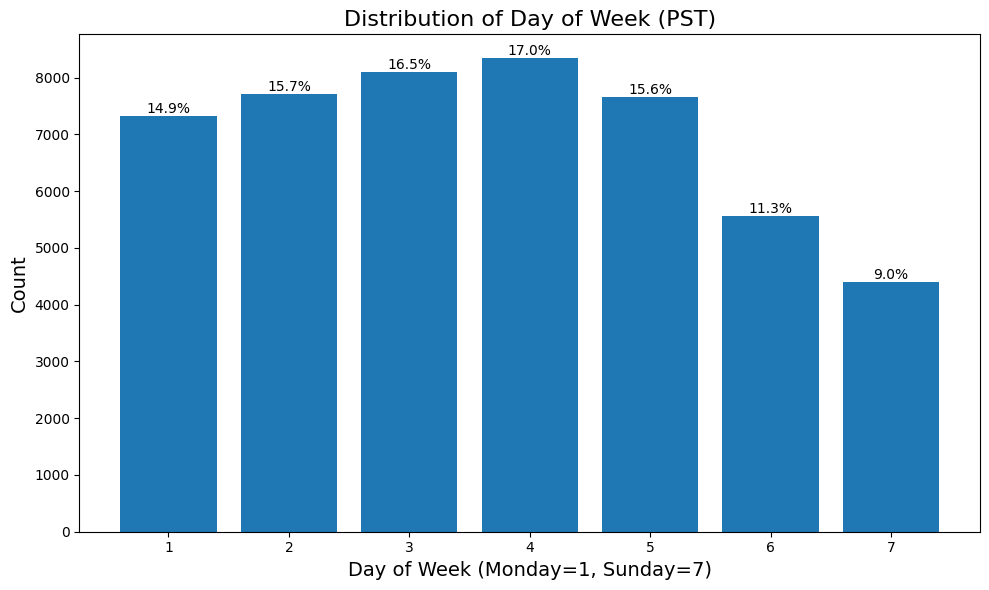

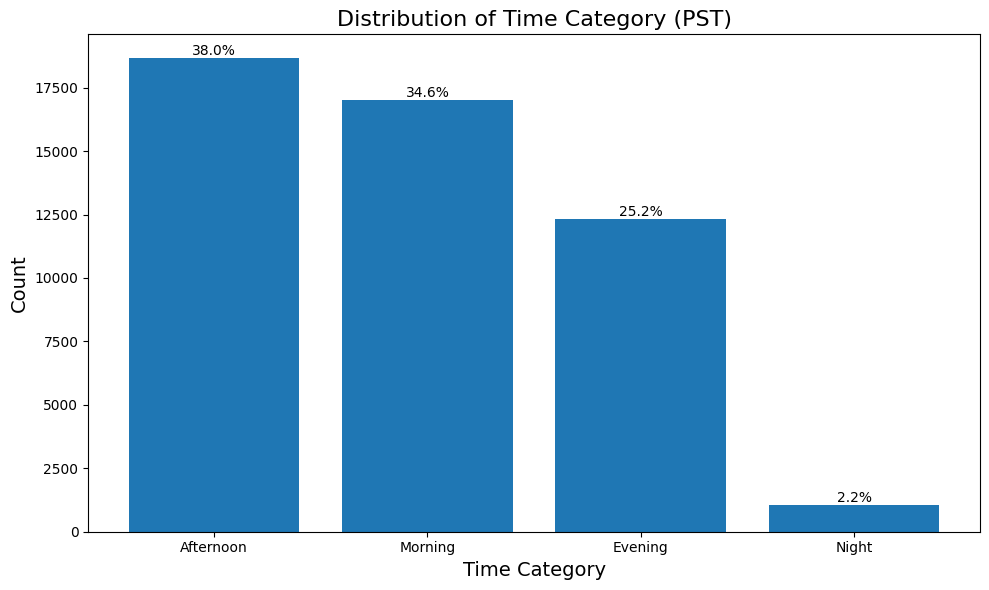

In [14]:
# Plot distribution of `day_of_week_pst`
day_of_week_counts = augmented['day_of_week_pst'].value_counts().sort_index()
day_of_week_percentages = (day_of_week_counts / len(augmented)) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(day_of_week_counts.index, day_of_week_counts.values, tick_label=day_of_week_counts.index)

for bar, percent in zip(bars, day_of_week_percentages):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax1.set_title("Distribution of Day of Week (PST)", fontsize=16)
ax1.set_xlabel("Day of Week (Monday=1, Sunday=7)", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

# Plot distribution of `time_category_pst`
time_category_counts = augmented['categorized_created_at_pst'].value_counts()
time_category_percentages = (time_category_counts / len(augmented)) * 100

fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(time_category_counts.index, time_category_counts.values, 
               tick_label=time_category_counts.index)

for bar, percent in zip(bars, time_category_percentages):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax2.set_title("Distribution of Time Category (PST)", fontsize=16)
ax2.set_xlabel("Time Category", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2094,1.217446e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.502932e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.909835e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1505,3.597401e+03,1.228000e+03,5.600000e+01,5.908050e+05,5.907490e+05,154,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.449668e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2070,NaN,NaN,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,181,3.410018e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22590,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,45844,45844.0,3227.0,93.423814,6.576186
8,likes_count,Int64,0.000000,716,6.490836e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,47594,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN


### Handle NAs


Impute NAs in has_audio as True?
`cleaned_data["has_audio"] = cleaned_data["has_audio"].fillna(True)`

Impute NAs in video_view_count with the average ratio of video_view_count to like_count?


In [16]:
# Compare engagement metrics between videos with and without view counts
augmented.groupby(augmented['video_view_count'].isna())[["likes_count", "comments_count", "video_duration"]].describe()

# No obvious systematic differences in critical engagement metrics

likes_count                                                 \
                       count       mean          std  min   25%   50%   75%   
video_view_count                                                              
False                41487.0  70.756574  1975.666565  0.0   7.0  16.0  35.0   
True                  7584.0  32.916667     96.03158  0.0  10.0  20.0  38.0   

                           comments_count            ...               \
                       max          count      mean  ...  75%     max   
video_view_count                                     ...                
False             336276.0        41487.0  3.583677  ...  3.0  2863.0   
True                7177.0         7584.0  2.460047  ...  3.0   170.0   

                 video_duration                                             \
                          count       mean         std  min   25%      50%   
video_view_count                                                             
False                   41487.0   68.14409  126.981815  1.0  18.9   45.333   
True                     7584.0  60.738832   85.498234  1.0  14.7  37.1005   

                                     
                      75%       max  
video_view_count                     
False              82.434  9156.509  
True              61.7505  1965.645  

[2 rows x 24 columns]

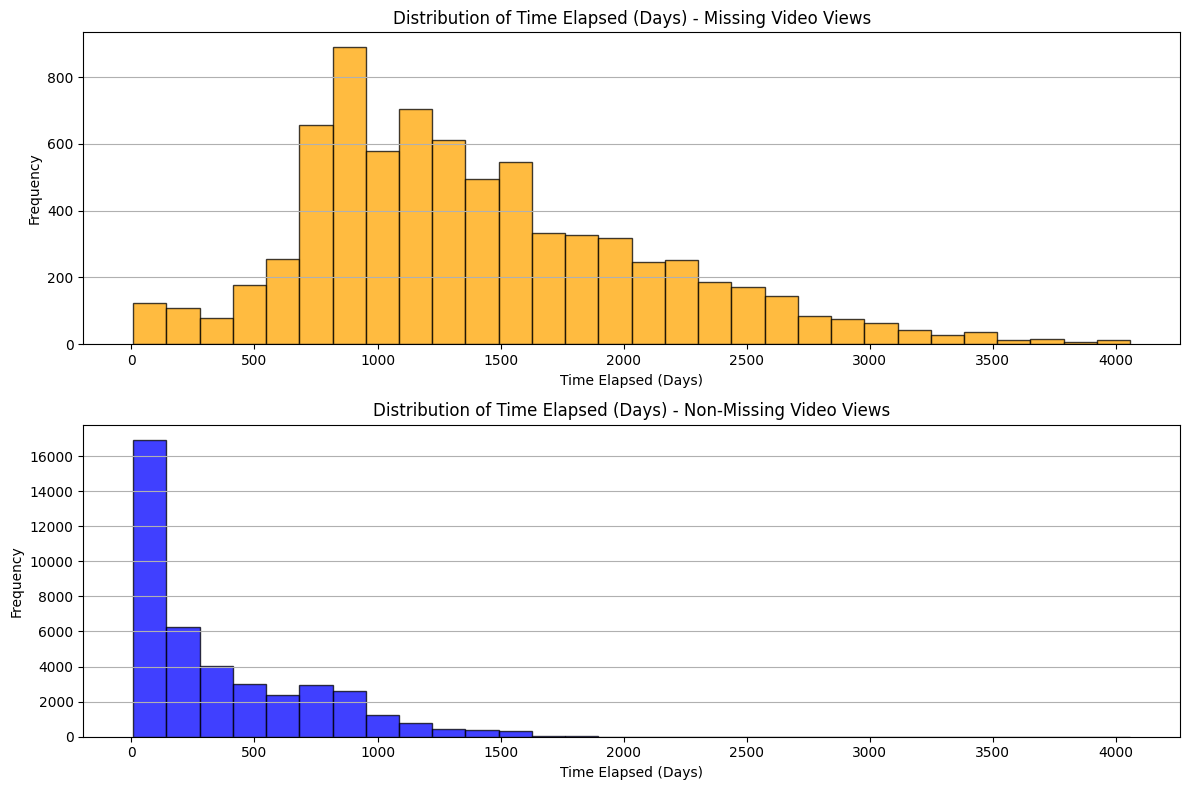

In [17]:
# Define common bin edges for the histos
bin_edges = np.histogram_bin_edges(
    pd.concat([augmented[augmented['video_view_count'].isna()]['time_elapsed'].dt.days, augmented[~augmented['video_view_count'].isna()]['time_elapsed'].dt.days]),
    bins=30
)

# Create figure
plt.figure(figsize=(12, 8))

# Plot histogram for missing `video_view_count`
plt.subplot(2, 1, 1)
plt.hist(
    augmented[augmented['video_view_count'].isna()]['time_elapsed'].dt.days, 
    bins=bin_edges, 
    alpha=0.75, 
    color='orange', 
    edgecolor='black'
)
plt.title('Distribution of Time Elapsed (Days) - Missing Video Views')
plt.xlabel('Time Elapsed (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Plot histogram for non-missing `video_view_count`
plt.subplot(2, 1, 2)
plt.hist(
    augmented[~augmented['video_view_count'].isna()]['time_elapsed'].dt.days, 
    bins=bin_edges, 
    alpha=0.75, 
    color='blue', 
    edgecolor='black'
)
plt.title('Distribution of Time Elapsed (Days) - Non-Missing Video Views')
plt.xlabel('Time Elapsed (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()

# Seems that the missingness was not random. It's more likely for an older reel to miss view counts. Maybe apply RF for imputation or just drop it (15% is a lot but it saves time and we still have about 40k rows).

### Try fitting a predictive model to impute NAs in video views

#### Preprocessing data

In [18]:
# Preprocess data
# Get time elasped in seconds
augmented["time_elapsed_seconds"] = augmented["time_elapsed"].dt.total_seconds()

# Encode has_audio
augmented["has_audio"] = augmented["has_audio"].astype(pd.Int64Dtype())

# One-Hot Encode 'day_of_week_pst' and 'categorized_created_at_pst'
day_of_week_dummies = pd.get_dummies(
    augmented["day_of_week_pst"],
    prefix="day",
    drop_first=True,  # Use Monday as reference
).astype(pd.Int64Dtype())
time_category_dummies = pd.get_dummies(
    augmented["categorized_created_at_pst"],
    prefix="time_cat",
    drop_first=True,  # Use Evening as reference
).astype(pd.Int64Dtype())

# Concatenate the dummy variables to the dataframe
augmented = pd.concat([augmented, day_of_week_dummies, time_category_dummies], axis=1)

# Define features selected
X_COLS = [
    "total_posts",
    "followers",
    "followings",
    # "comments_count",  # Removed due to the multicollinearity issue with likes_count
    "has_audio",  # Encoded into binary 0 or 1
    "likes_count",  # .9 correlation with views; assuming no data leakage;
    "video_duration",
    "time_elapsed_seconds",
    # "day_of_week_pst",  # One-hot encoded
    # "categorized_created_at_pst",  # One-hot encoded
] + list(day_of_week_dummies.columns) + list(time_category_dummies.columns)
Y_COL = "video_view_count"

# del day_of_week_dummies, time_category_dummies; gc.collect()

train_data = augmented[augmented["video_view_count"].notna()].copy()
missing_data = augmented[augmented["video_view_count"].isna()].copy()
train_data

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,...,time_elapsed_seconds,day_2,day_3,day_4,day_5,day_6,day_7,time_cat_Morning,time_cat_Afternoon,time_cat_Evening
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,1,7,2024-04-09 21:36:44+00:00,...,9775367.0,1,0,0,0,0,0,0,1,0
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,1,10,2024-03-27 21:06:10+00:00,...,10900401.0,0,1,0,0,0,0,0,1,0
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2024-03-15 21:46:53+00:00,...,11934758.0,0,0,0,1,0,0,0,1,0
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2024-03-15 21:34:27+00:00,...,11935504.0,0,0,0,1,0,0,0,1,0
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,1,7,2024-03-14 19:57:06+00:00,...,12027745.0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75380,1444154,6,692,509,486,2024-08-01 20:26:53+00:00,0,1,3,2024-01-20 22:30:58+00:00,...,16754155.0,0,0,0,0,1,0,0,1,0
75381,1444154,7,692,509,486,2024-08-01 20:26:53+00:00,0,1,4,2024-01-20 17:59:59+00:00,...,16770414.0,0,0,0,0,1,0,1,0,0
75382,1444154,8,692,509,486,2024-08-01 20:26:53+00:00,0,1,2,2024-01-20 03:43:11+00:00,...,16821822.0,0,0,0,1,0,0,0,0,1
75383,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,1,1,2024-01-18 02:54:49+00:00,...,16997524.0,0,1,0,0,0,0,0,0,1


#### Examine distributions

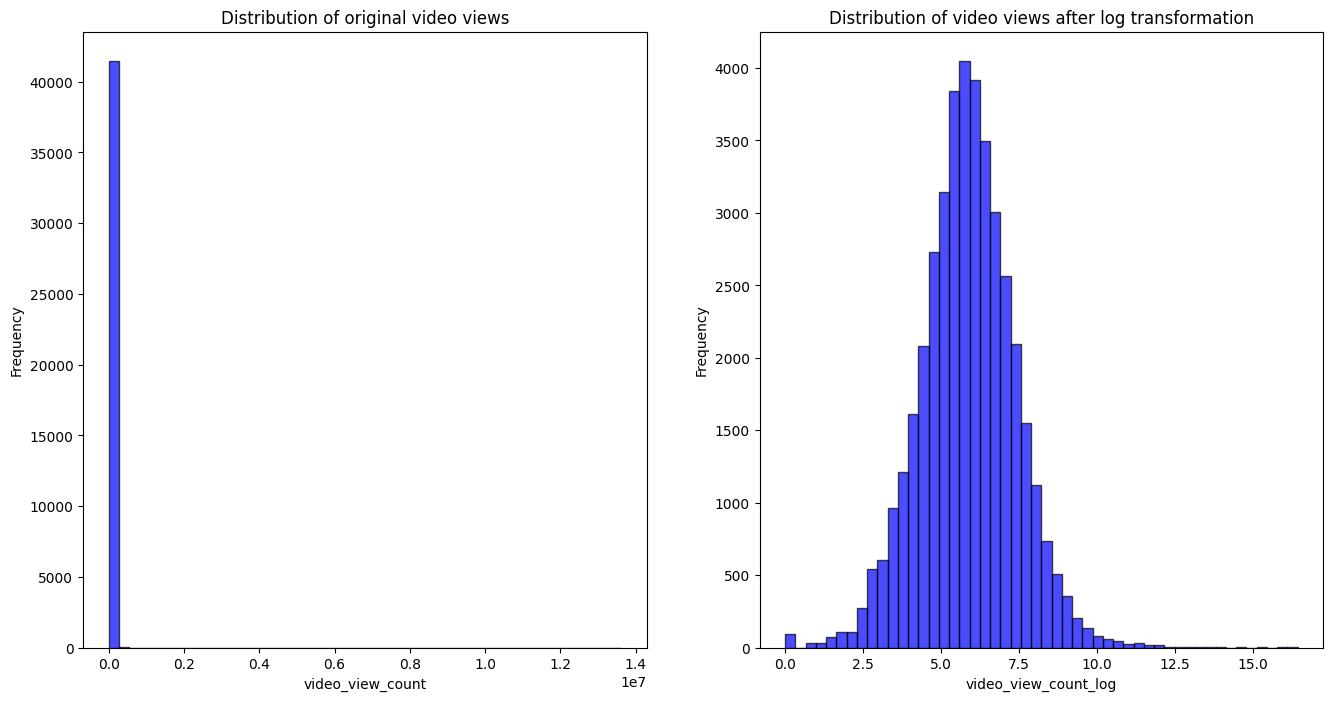

In [19]:
# Plot distribution
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.hist(train_data[Y_COL], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of original video views')
plt.xlabel('video_view_count')
plt.ylabel('Frequency')
# plt.show()

# Highly skewed to the right
train_data['video_view_count_log'] = np.log1p(train_data[Y_COL])  # Get log(1+x) as view can be 0
Y_COL_TRANSFORMED = 'video_view_count_log'

# Plot again, satisfied
plt.subplot(1, 2, 2)
plt.hist(train_data[Y_COL_TRANSFORMED], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of video views after log transformation')
plt.xlabel('video_view_count_log')
plt.ylabel('Frequency')
plt.show()

#### Examine correlation

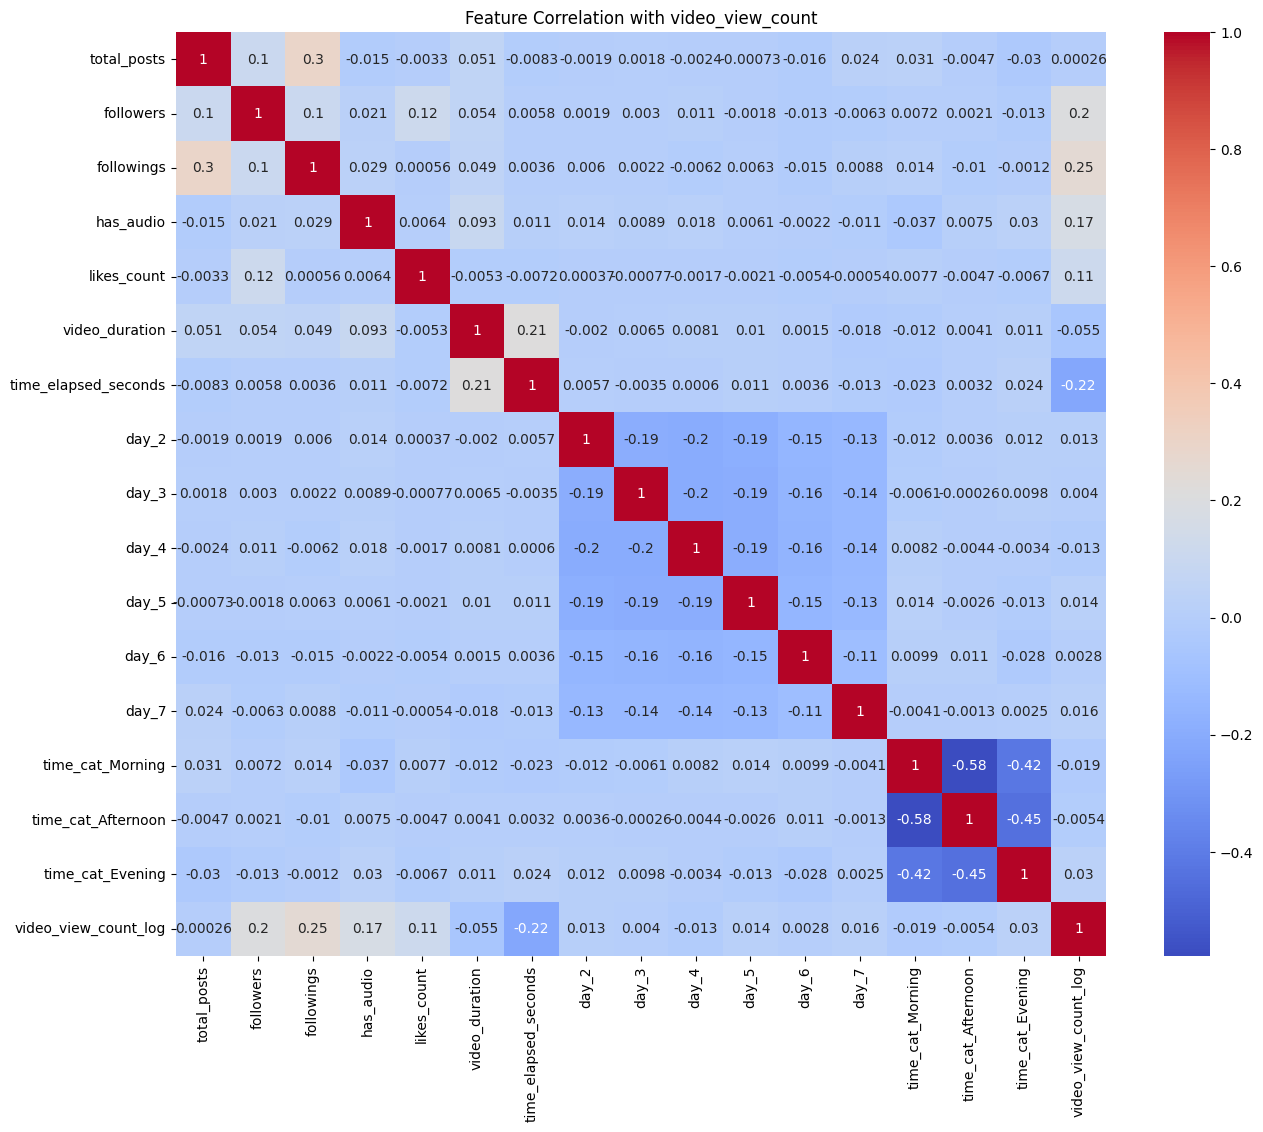

In [20]:
import seaborn as sns
corr_matrix = train_data[X_COLS + [Y_COL_TRANSFORMED]].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with video_view_count")
plt.show()

# High positive correlation found in likes_count and comments_count (0.73); Dropping comments_count;

# High negative correlation found in time_cat (around -0.50) is normal due to the nature of one-hot encoding.
# It's not a concern in RF. But in case other models (e.g., linear regression), it might introduce multicollinearty issues.
# So we drop the first categories in time_cat (and day_of_week, because why not) to reduce potential multicollinearity.

### Fit a Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = train_data[X_COLS]
y = train_data[Y_COL_TRANSFORMED]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

# Used hyperparameters tuned by Grid and Randomized CV Search
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,  # Make reproducible
)
rf.fit(X_train, y_train)  # Takes about 1 minutes?
rf.score(X_valid, y_valid)  # R-squared Score: 0.8304

0.8303973648258062

#### (Optional) Tuning Hyperparameters
Run with caution!! Takes about 9 minutes to search.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5],
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
)
# grid_search_rf.fit(X_train, y_train)
# print(f'Grid Best Random Forest parameters: {grid_search_rf.best_params_}')
# print("="*33)
# Grid Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

# Try also RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
# random_search_rf.fit(X_train, y_train)
# print(f'Randomized Best Random Forest parameters: {random_search_rf.best_params_}')
# Randomized Best Random Forest parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  12.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.5s
[CV] END ma

/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  12.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estim

/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  17.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  17.5s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; tot

### Model Evaluation and Validation

Suppose that the random forest is the best model. We place the imputed values back to `augmented`.

In [26]:
# Generate predictions on missing data
imputed_log_views = rf.predict(missing_data[X_COLS])

# Convert the logged views back
imputed_values = np.expm1(imputed_log_views).round().astype(int)  # Since we used p1, we use m1 here
imputed = augmented.copy()
imputed["is_view_count_imputed"] = imputed[Y_COL].isna().astype(pd.Int64Dtype())
imputed.loc[augmented[Y_COL].isna(), Y_COL] = imputed_values
summarize_dataframe(imputed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,user_id,Int64,0.0,2094,1.217446e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36
1,reel_id,Int64,0.0,36,1.502932e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920
2,total_posts,Int64,0.0,1022,6.909835e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217
3,followers,Int64,0.0,1505,3.597401e+03,1.228000e+03,5.600000e+01,5.908050e+05,5.907490e+05,154
4,followings,Int64,0.0,1430,1.449668e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143
5,scraped_at,"datetime64[s, UTC]",0.0,2070,NaN,NaN,NaN,NaN,NaN,71
6,comments_count,Int64,0.0,181,3.410018e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22590
7,has_audio,Int64,0.0,2,9.342381e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,45844
8,likes_count,Int64,0.0,716,6.490836e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015
9,created_at,"datetime64[s, UTC]",0.0,47594,NaN,NaN,NaN,NaN,NaN,4


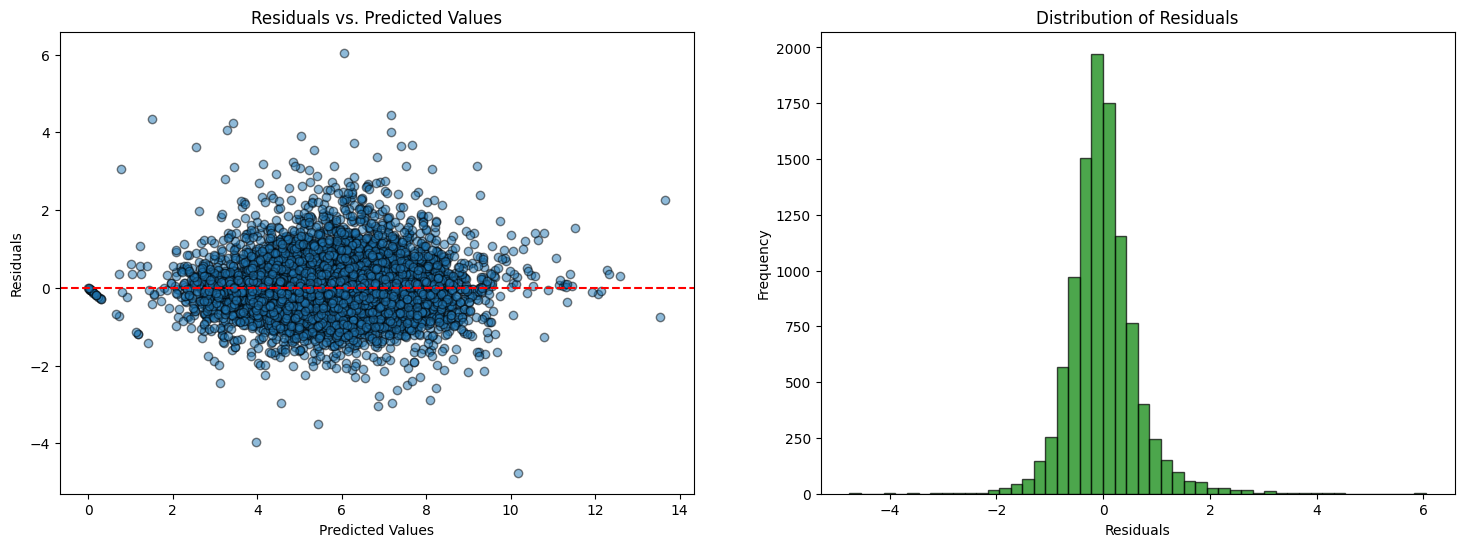

In [24]:
# Calculate residuals
residuals = y_valid - rf.predict(X_valid)

# Scatter plot of residuals vs. predicted values
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.scatter(rf.predict(X_valid), residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

# Distribution of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# The RF model appears well fitted, with residuals having no clear pattern, supporting the linearity and equal-variance assumption.

### Aggregation

#### Handle the non-independency between users

We aim to address some confounding issues by (1) assuming similar themes in contents, and (2) adjusting engagement metrics (e.g., `likes_count`) based on user-specific metrics (e.g., `followers` or `video_view_count`) to make comparisons across users with different audience sizes meaningful. However, we do not have the data to address other qualitative factors like content quality, visual effects, music vibes, etc, which are typically consistent within a user but vary significantly across users, introducing potential user-level correlations. For example, a single influencer might have 36 popular reels posted all on Monday morning. Even their engagement metrics are adjusted, the numerous observations are deemed as independent records, leading to biases unexpectedly.

To address the potential correlations, we will aggregate reels and average their metrics at User-Day-Time level. The pros are that we reduce the issue of multiple dependent reels within the same day-time slot, and that the dataset is simplified and the model will be straightforward. The cons could be the loss in data granularity and variability (a 50% reduction, in fact, from 49k to 24k), or imbalanced data.

However, since a single user can contribute to multiple day-time bins, user-specific characteristics still influence multiple observations, introducing dependence. Even if we conduct many tests, with each sampling some users in each bin, this is not feasible because we cannot guarantee, or manipulate, that the sampling is picking each user ID at most once during each sampling/test (i.e., if randomly chosen, no control at all; if artificially picked, how do you justify which reel of a user you pick or do you go through all possible permutations?). Therefore, the question now is: are we able to address the user-specific dependency between day-time combinations? Or shall we risk ourselves to accept significance when it is possibly due to repeated measures from the same user?

For now, yes, we want to take the risk to consider qualitative factors as already being reflected in normalized quantitative metrics. Our assumption is that, factors like content quality or video style, are inherently captured by quantitative metrics such as likes, comments, views, and followers. By adjusting these metrics based on user-specific features, we mitigate the impact of varying audience sizes, which indirectly accounting for the qualitative factors that we couldn't measure. In short, we use the normalized engagement metrics as proxies for both quantitative and partial qualitative aspects, thereby reducing but not entirely eliminating user-specific influences. Under this assumption, we must acknowledge that the engagement metrics do not fully capture nuanced qualitative factors like creativity, visual appeal, etc, we are not entirely mitigating the residual correlations.

With this assumption, we have the normality and equal-vairance assumptions met, thus we can proceed to ANOVA and Post-Hoc tests if ANOVA is significant.

A side note is that, there are advanced modeling capable for addressing the residual dependencies we mentioned above (e.g., Mixed-Effects Model). We might want to compare their results at the very end.

In [35]:
summarize_dataframe(imputed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,user_id,Int64,0.0,2094,1.217446e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36
1,reel_id,Int64,0.0,36,1.502932e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920
2,total_posts,Int64,0.0,1022,6.909835e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217
3,followers,Int64,0.0,1505,3.597401e+03,1.228000e+03,5.600000e+01,5.908050e+05,5.907490e+05,154
4,followings,Int64,0.0,1430,1.449668e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143
5,scraped_at,"datetime64[s, UTC]",0.0,2070,NaN,NaN,NaN,NaN,NaN,71
6,comments_count,Int64,0.0,181,3.410018e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22590
7,has_audio,Int64,0.0,2,9.342381e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,45844
8,likes_count,Int64,0.0,716,6.490836e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015
9,created_at,"datetime64[s, UTC]",0.0,47594,NaN,NaN,NaN,NaN,NaN,4


In [61]:
# Aggregate by user-day-time combination
aggregated = imputed.groupby(
    by=['user_id', 'day_of_week_pst', 'categorized_created_at_pst'],
).agg(
    {
        'total_posts': 'mean',
        'followers': 'mean',
        'followings': 'mean',
        'likes_count': 'mean',
        'comments_count': 'mean',
        'video_view_count': 'mean',
        'video_duration': 'mean',
    }
).dropna().reset_index()

# Replace 2-col bin with 1-col bin
aggregated['day_time_group'] = aggregated['day_of_week_pst'].astype(str) + '_' + aggregated['categorized_created_at_pst'].astype(str)

# Devise engagement velocity metric
# (For each 100 views, how many likes+comments can it gain?)
# x
# (For each 100 followers, how many views can it gain?)
aggregated['EPF'] = (aggregated['likes_count'] + aggregated['comments_count']) / aggregated['followers'] * 100
aggregated['EPV'] = (aggregated['likes_count'] + aggregated['comments_count']) / (aggregated['video_view_count'] + 1) * 100
aggregated = aggregated[aggregated['EPF'] < 2000].sort_values(['EPF'])
aggregated

/tmp/ipykernel_9000/853951762.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = imputed.groupby(


,user_id,day_of_week_pst,categorized_created_at_pst,total_posts,followers,followings,likes_count,comments_count,video_view_count,video_duration,day_time_group,EPF,EPV
10230,1207681,5,Afternoon,1190.0,1466.0,3580.0,0.0,0.0,31.0,43.066,5_Afternoon,0.0,0.0
1040,1021519,3,Afternoon,269.0,414.0,149.0,0.0,0.0,7.0,11.2,3_Afternoon,0.0,0.0
3029,1097067,2,Morning,714.0,612.0,432.0,0.0,0.0,28.0,10.0,2_Morning,0.0,0.0
12037,1223231,5,Night,629.0,284.0,642.0,0.0,0.0,2.0,58.299,5_Night,0.0,0.0
1696,1025048,1,Afternoon,2541.0,376.0,211.0,0.0,0.0,23.5,87.6265,1_Afternoon,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13503,1237013,3,Morning,262.0,15240.0,1231.0,37540.0,700.0,1551047.666667,83.855,3_Morning,250.918635,2.465429
10578,1210275,1,Evening,51.0,1504.0,214.0,5367.0,6.666667,135597.0,29.510667,1_Evening,357.291667,3.962939
10851,1213086,1,Morning,531.0,2690.0,784.0,9945.0,64.0,28171.0,140.223,1_Morning,372.081784,35.528184
23769,1383599,2,Evening,45.0,708.0,1243.0,3053.5,14.0,81301.0,26.366,2_Evening,433.262712,3.77297


0.0
0.0


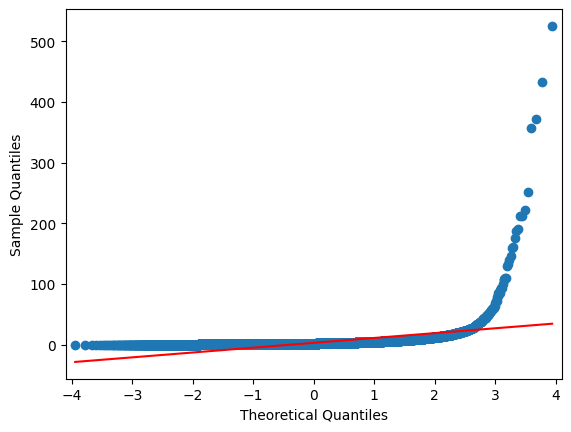

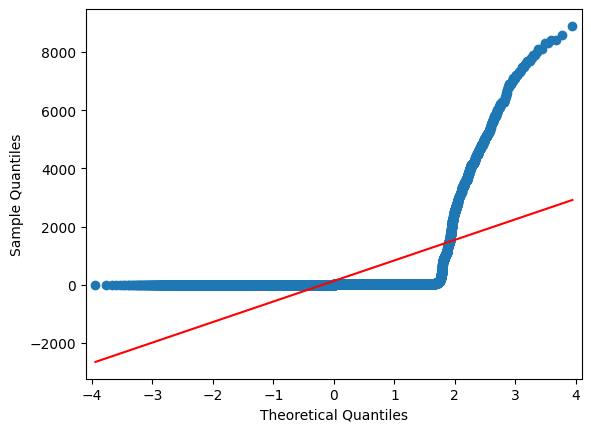

LeveneResult(statistic=np.float64(1.117906854409773), pvalue=np.float64(0.30611208990527133))
LeveneResult(statistic=np.float64(3.1201330723707374), pvalue=np.float64(8.764136337149713e-08))
F_onewayResult(statistic=np.float64(1.193208428343362), pvalue=np.float64(0.22432550106184762))


/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
1_Afternoon   1_Evening   0.8424 0.7141 -0.3854 2.0702  False
1_Afternoon   1_Morning   0.3594    1.0 -0.8464 1.5651  False
1_Afternoon     1_Night  -0.0068    1.0 -2.9193 2.9057  False
1_Afternoon 2_Afternoon   0.1887    1.0  -0.976 1.3535  False
1_Afternoon   2_Evening   0.7424  0.897 -0.4839 1.9687  False
1_Afternoon   2_Morning   0.1556    1.0 -1.0287 1.3399  False
1_Afternoon     2_Night   0.2452    1.0 -2.6792 3.1697  False
1_Afternoon 3_Afternoon   0.4235 0.9999 -0.7192 1.5662  False
1_Afternoon   3_Evening   0.2158    1.0 -0.9984 1.4301  False
1_Afternoon   3_Morning  -0.0512    1.0 -1.2247 1.1224  False
1_Afternoon     3_Night   0.7096    1.0 -2.2029 3.6221  False
1_Afternoon 4_Afternoon  -0.0563    1.0  -1.205 1.0924  False
1_Afternoon   4_Evening   0.2379    1.0 -0.9746 1.4504  False
1_Aftern

In [64]:
# ANOVA
# Normality test
print(stats.normaltest(aggregated['EPF']).pvalue)
print(stats.normaltest(aggregated['EPV']).pvalue)

import statsmodels.api as sm
sm.qqplot(aggregated['EPF'], line='s')
sm.qqplot(aggregated['EPV'], line='s')
plt.show()

# Equal-Variance
print(stats.levene(*[group['EPF'].values for _, group in aggregated.groupby('day_time_group')]))  # Equal
print(stats.levene(*[group['EPV'].values for _, group in aggregated.groupby('day_time_group')]))  # Non-equal

# Perform ANOVA
groups = [group['EPF'].values for _, group in aggregated.groupby('day_time_group')]
print(stats.f_oneway(*groups))

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=aggregated['EPF'],
                          groups=aggregated['day_time_group'],
                          alpha=0.05)
print(tukey.summary())

### Output CSV

In [25]:
columns_to_drop = [
    "created_at",
    "created_at_timestamp",
    "scraped_at",
    "scraped_at_timestamp",
    "time_elapsed",
    "time_elapsed_category",
] + list(day_of_week_dummies.columns) + list(time_category_dummies.columns)
final = imputed.drop(columns=columns_to_drop)
summarize_dataframe(final)
# final.to_csv("../data/processed/cleaned.csv")

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,user_id,Int64,0.0,2094,1.217446e+06,1224878.0,1018408.0,1.445323e+06,4.269150e+05,36
1,reel_id,Int64,0.0,36,1.502932e+01,14.0,1.0,3.600000e+01,3.500000e+01,1920
2,total_posts,Int64,0.0,1022,6.909835e+02,474.0,12.0,3.075500e+04,3.074300e+04,217
3,followers,Int64,0.0,1505,3.597401e+03,1228.0,56.0,5.908050e+05,5.907490e+05,154
4,followings,Int64,0.0,1430,1.449668e+03,1075.0,0.0,7.535000e+03,7.535000e+03,143
5,comments_count,Int64,0.0,181,3.410018e+00,1.0,0.0,2.863000e+03,2.863000e+03,22590
6,has_audio,Int64,0.0,2,9.342381e-01,1.0,0.0,1.000000e+00,1.000000e+00,45844
7,likes_count,Int64,0.0,716,6.490836e+01,17.0,0.0,3.362760e+05,3.362760e+05,3015
8,video_duration,Float64,0.0,15801,6.699960e+01,44.5,1.0,9.156509e+03,9.155509e+03,754
9,video_view_count,Int64,0.0,5230,1.961716e+03,298.0,0.0,1.361887e+07,1.361887e+07,1477
